In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization

# Import PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler # preprocessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # evaluation metrics
from sklearn.linear_model import LinearRegression # linear regression model

from itertools import product # Import itertools for generating combinations
import heapq # Import heapq for getting top elements from a list

## **Data**

In [464]:
# Read the CSV file into a DataFrame
# file_address = 'data/ibex.csv'
# file_address = 'data/gdaxi.csv'
file_address = 'data/dji.csv'

index_name = file_address.split('/')[-1].split('.')[0].upper()

df = pd.read_csv(file_address)

# Convert the 'date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Drop 'Volume' and 'Adj Close' columns
df = df.drop(['Volume', 'Adj Close'], axis=1)

In [465]:
df

,Open,High,Low,Close
Date,,,,
2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000
2011-01-04,11670.900391,11698.219727,11635.740234,11691.179688
2011-01-05,11688.610352,11742.679688,11652.889648,11722.889648
2011-01-06,11716.929688,11736.740234,11667.459961,11697.309570
2011-01-07,11696.860352,11726.940430,11599.679688,11674.759766
...,...,...,...,...
2019-12-24,28572.570312,28576.800781,28503.210938,28515.449219
2019-12-26,28539.460938,28624.099609,28535.150391,28621.390625
2019-12-27,28675.339844,28701.660156,28608.980469,28645.259766


In [466]:
# Define the split date
split_date = pd.to_datetime('2019-01-01')

# Split the data into train and test sets
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

In [467]:
def split_data_x(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index: index + time_window].reshape(-1))

    out = np.array(data)
    
    return out

In [468]:
def split_data_y(df, time_window):
    """
    Split a DataFrame into input sequences of a specified time window.
    this function is for x
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        time_window (int): The length of each input sequence.

    Returns:
        np.ndarray: Numpy array of input sequences.

    """
    df = df['Close'] # only need the close price as y
    data_raw = np.array(df)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - time_window):
        data.append(data_raw[index + time_window])

    out = np.array(data)
    out = np.expand_dims(out, axis=1)

    return out

# **Strategies**

In [469]:
def calculate_profit_factor(strategy):
    """
    Calculate the profit factor of a trading strategy.

    Args:
        strategy (pd.Series): A pandas Series representing the strategy's trade outcomes.

    Returns:
        float: The profit factor of the strategy.
    """
    positive_trades = strategy.loc[strategy > 0].sum() # Calculate the sum of positive trades
    negative_trades = strategy.loc[strategy < 0].sum() # Calculate the sum of negative trades
    profit_factor = abs(positive_trades / negative_trades) # Calculate the profit factor
    return profit_factor

In [470]:
def calculate_metrics(df):
    # Calculate number of trades
    num_trades = df['Trades'].sum()
    
    # Calculate net profit of the trades
    net_profit = df['PriceStrategy'].sum()
    
    # Calculate profit factor
    profit_factor = calculate_profit_factor(df['Strategy'])
    
    # Calculate average net of each trade
    avg_net_trade = net_profit / num_trades
    
    # Calculate maximum drawdown (price)
    max_drawdown = (df['CPriceStrategy'] - df['CPriceStrategy'].cummax()).min()
    
    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Number of Trades': [num_trades],
        'Net Profit': [net_profit],
        'Profit Factor': [profit_factor],
        'Average Net per Trade': [avg_net_trade],
        'Maximum Drawdown': [max_drawdown],
    }, index=['Strategy'])
    
    return metrics_df

## **TEMA**

In [471]:
def ema(df, period):
    """
    Calculate the Exponential Moving Average (EMA) of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        period (int): The number of periods to consider for the EMA calculation.

    Returns:
        pd.DataFrame: The DataFrame with EMA values.

    """
    return df.ewm(span = period, min_periods = period).mean() 

In [472]:
def df_change(df, symbol):
    """
    Create a DataFrame with a single column representing the change in closing prices.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the change in closing prices.

    Returns:
        pd.DataFrame: A DataFrame with a single column representing the change in closing prices.

    """
    temp = pd.DataFrame(df['Close']) # Create a temporary DataFrame with 'Close' column
    temp = temp.rename({'Close': symbol}, axis=1) # Rename the 'Close' column to the specified symbol
    return temp

In [473]:
def tema_strategy(df, symbol, short_period, mid_period, long_period):
    """
    Implement a trading strategy using TEMA (Triple Exponential Moving Average).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for short-term EMA calculation.
        mid_period (int): The period for mid-term EMA calculation.
        long_period (int): The period for long-term EMA calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the EMA values for short, mid, and long periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Determine the position based on EMA crossovers
    temp['Position'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [474]:
def optimize_tema_parameters(df, symbol, short_range, mid_range, long_range):
    """
    Optimize TEMA (Triple Exponential Moving Average) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        mid_range (list): A list of mid-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, mid, and long periods
    for short_period, mid_period, long_period in product(short_range, mid_range, long_range):
        if short_period < mid_period < long_period:
            
            # Calculate TEMA strategy performance for the combination of periods
            result = tema_strategy(df, symbol, short_period, mid_period, long_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, mid_period, long_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [475]:
# Define the parameter ranges
short_range = range(2, 25)
mid_range = range(5, 41)
long_range = range(8, 81)

# test parameters
short_range = range(2, 5)
mid_range = range(5, 7)
long_range = range(8, 12)

# Run the optimization
best_combinations, best_c_strategy = optimize_tema_parameters(train_data, index_name, short_range, mid_range, long_range)
best_tema_params = best_combinations[0]

# Print the results
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 5, 8)
Combination 2: (2, 6, 8)
Combination 3: (2, 5, 9)
Combination 4: (3, 5, 8)
Combination 5: (2, 5, 11)
Best CStrategy: [0.9305252503355033, 0.8561688553789933, 0.8376660051532777, 0.8311288443227677, 0.8290901820192764]


In [513]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = tema_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (2, 5, 5)
Profit Factor: 1.0701635721165723

Combination 2: (3, 5, 5)
Profit Factor: 1.2813761509432564

Combination 3: (2, 6, 7)
Profit Factor: 1.3350755493523883

Combination 4: (2, 5, 8)
Profit Factor: 1.1822776726395952

Combination 5: (2, 6, 5)
Profit Factor: 1.1970898328006567



In [510]:
tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2])

,DJI,ShortEMA,MidEMA,LongEMA,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,
2019-01-02,23346.240234,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,22686.220703,22851.225586,NaN,NaN,0,-0.028678,-0.000000,-660.019531,-0.000000,0.0,0.971729,1.000000,-660.019531,0.000000
2019-01-04,23433.160156,23254.103365,NaN,NaN,0,0.032394,0.000000,746.939453,0.000000,0.0,1.003723,1.000000,86.919922,0.000000
2019-01-07,23531.349609,23441.244580,NaN,NaN,0,0.004181,0.000000,98.189453,0.000000,0.0,1.007929,1.000000,185.109375,0.000000
2019-01-08,23787.449219,23673.001404,23502.744890,NaN,0,0.010825,0.000000,256.099609,0.000000,0.0,1.018899,1.000000,441.208984,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.449219,28512.180778,28434.620487,28353.782326,1,-0.001264,-0.001264,-36.080078,-36.080078,0.0,1.221415,1.103428,5169.208984,2593.208984
2019-12-26,28621.390625,28584.987343,28496.877200,28413.250837,1,0.003708,0.003708,105.941406,105.941406,0.0,1.225953,1.107527,5275.150391,2699.150391
2019-12-27,28645.259766,28625.168958,28546.338055,28464.808376,1,0.000834,0.000834,23.869141,23.869141,0.0,1.226975,1.108451,5299.019531,2723.019531


In [477]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,59.0,2539.900391,1.182278,43.049159,-2763.917969


## **MACD**

In [478]:
def macd_strategy(df, symbol, short_period, long_period, signal_period):
    """
    Implement a trading strategy using MACD (Moving Average Convergence Divergence).

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_period (int): The period for the short-term EMA calculation.
        long_period (int): The period for the long-term EMA calculation.
        signal_period (int): The period for the signal line calculation.

    Returns:
        pd.DataFrame: A DataFrame containing the trading strategy signals and performance metrics.

    """
    
    df = df_change(df, symbol) # Calculate the change in closing prices
    temp = df.copy() # Create a copy of the DataFrame
    
    # Calculate the short-term and long-term EMAs and MACD line
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Generate trading signals based on MACD and signal line crossovers
    temp['Position'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy performance, cumulative price, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [479]:
def optimize_macd_parameters(df, symbol, short_range, long_range, signal_range):
    """
    Optimize MACD (Moving Average Convergence Divergence) parameters by finding top combinations based on CStrategy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        symbol (str): The name of the column representing the price data.
        short_range (list): A list of short-term EMA period values to consider.
        long_range (list): A list of long-term EMA period values to consider.
        signal_range (list): A list of signal line period values to consider.

    Returns:
        list: A list of best parameter combinations.
        list: A list of corresponding CStrategy values.

    """
    top_combinations = []
    
    # Iterate over all combinations of short, long, and signal periods
    for short_period, long_period, signal_period in product(short_range, long_range, signal_range):
        if short_period < long_period:
            
            # Calculate MACD strategy performance for the combination of periods
            result = macd_strategy(df, symbol, short_period, long_period, signal_period)
            c_strategy = result['CStrategy'].iloc[-1]
            
            # Use a heap to maintain the top 5 combinations based on CStrategy
            if len(top_combinations) < 5:
                heapq.heappush(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
            else:
                heapq.heappushpop(top_combinations, (c_strategy, (short_period, long_period, signal_period)))
    
    # Get the top 5 combinations with highest CStrategy values
    top_combinations = sorted(top_combinations, reverse=True)
    best_combinations = [combo[1] for combo in top_combinations]
    best_c_strategy = [combo[0] for combo in top_combinations]
    
    return best_combinations, best_c_strategy

In [480]:
# Define the parameter ranges
short_range = range(2, 10)
long_range = range(5, 35)
signal_range = range(5, 20)

# test parameters
short_range = range(2, 5)
long_range = range(5, 7)
signal_range = range(5, 10)

# Run the optimization
best_combinations, best_c_strategy = optimize_macd_parameters(train_data, index_name, short_range, long_range, signal_range)
best_macd_params = best_combinations[0]

# Print the best combinations and CStrategy values
print("Best Combinations:")
for i, combination in enumerate(best_combinations):
    print(f"Combination {i+1}: {combination}")
print("Best CStrategy:", best_c_strategy)

Best Combinations:
Combination 1: (2, 5, 5)
Combination 2: (3, 5, 5)
Combination 3: (2, 6, 7)
Combination 4: (2, 5, 8)
Combination 5: (2, 6, 5)
Best CStrategy: [1.458223139247501, 1.350652581050076, 1.306776690068179, 1.2677566125046436, 1.2457572836058346]


In [516]:
print(f"Printing five of the best parameters combinations:\n")

for i, combination in enumerate(best_combinations):
    short_period, mid_period, long_period = combination
    
    # Run the strategy with the current combination
    strategy_result = macd_strategy(test_data, index_name, short_period, mid_period, long_period)
    
    # Calculate the profit factor
    pf_factor = calculate_profit_factor(strategy_result['Strategy'])
    
    # Print the result
    print(f"Combination {i+1}: {combination}")
    print("Profit Factor:", pf_factor)
    print()

Printing five of the best parameters combinations:

Combination 1: (2, 5, 5)
Profit Factor: 0.8869279531943643

Combination 2: (3, 5, 5)
Profit Factor: 0.9794502433396465

Combination 3: (2, 6, 7)
Profit Factor: 0.9514402633856853

Combination 4: (2, 5, 8)
Profit Factor: 0.9903659317960246

Combination 5: (2, 6, 5)
Profit Factor: 0.8545272811972298



In [514]:
macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2])

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,
2019-01-02,23346.240234,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,22686.220703,22851.225586,NaN,NaN,NaN,0,-0.028678,-0.000000,-660.019531,-0.000000,0.0,0.971729,1.000000,-660.019531,0.000000
2019-01-04,23433.160156,23254.103365,NaN,NaN,NaN,0,0.032394,0.000000,746.939453,0.000000,0.0,1.003723,1.000000,86.919922,0.000000
2019-01-07,23531.349609,23441.244580,NaN,NaN,NaN,0,0.004181,0.000000,98.189453,0.000000,0.0,1.007929,1.000000,185.109375,0.000000
2019-01-08,23787.449219,23673.001404,23502.744890,170.256514,NaN,0,0.010825,0.000000,256.099609,0.000000,0.0,1.018899,1.000000,441.208984,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.449219,28512.180778,28434.620487,77.560291,87.957844,-1,-0.001264,-0.001264,-36.080078,-36.080078,1.0,1.221415,0.923572,5169.208984,-1928.625000
2019-12-26,28621.390625,28584.987343,28496.877200,88.110143,88.008610,1,0.003708,-0.003708,105.941406,-105.941406,1.0,1.225953,0.920154,5275.150391,-2034.566406
2019-12-27,28645.259766,28625.168958,28546.338055,78.830903,84.949374,-1,0.000834,0.000834,23.869141,23.869141,1.0,1.226975,0.920921,5299.019531,-2010.697266


In [482]:
# macd strategy metric outputs
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-1903.876953,0.886928,-26.815168,-3099.941406


# **Prediction**

## **Linear Regression**

In [483]:
# setting up the lookback parameter
time_window = 24

In [484]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data, time_window)
y_train = split_data_y(train_data, time_window)
x_test = split_data_x(test_data, time_window)
y_test = split_data_y(test_data, time_window)

In [485]:
# printing shape of x and y data
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1988, 96)
y_train.shape =  (1988, 1)
x_test.shape =  (228, 96)
y_test.shape =  (228, 1)


In [486]:
# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [487]:
# Make predictions on the test set
y_pred = regression_model.predict(x_test)

In [488]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 152.89726919400718
Root Mean Squared Error (RMSE): 208.84356406907892
Symmetric Mean Absolute Percentage Error (sMAPE): 5.788623575157317
Mean Absolute Percentage Error (MAPE): 5.790190070675451


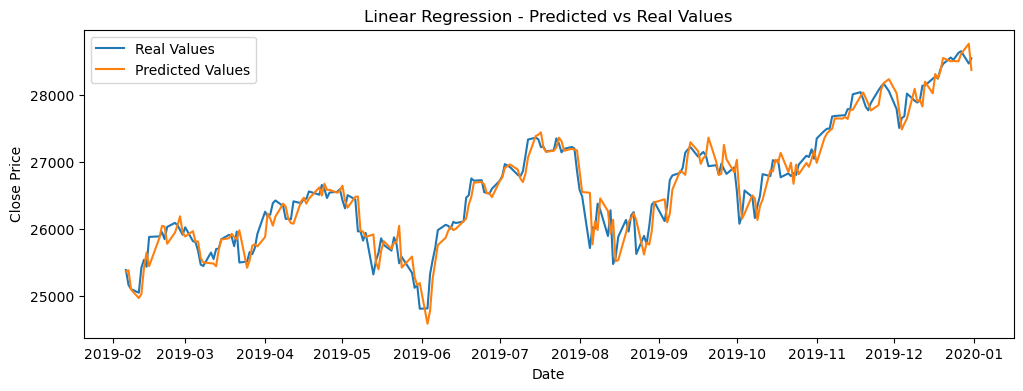

In [489]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression - Predicted vs Real Values')
plt.legend()
plt.show()

In [490]:
# saving the prediction price for further use
y_pred_lr = pd.DataFrame(y_pred)

# Rename the column
y_pred_lr = y_pred_lr.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_lr = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_lr],
                      ignore_index=True)

## **ANN**

In [491]:
# Define the neural network architecture
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x[:, -1] # Output only the last column (close price)

In [492]:
# Preprocess the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['Open', 'Close', 'High', 'Low']])
test_data_scaled = scaler.fit_transform(test_data[['Open', 'Close', 'High', 'Low']])

# Create a new DataFrame with scaled values and original column names
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Open', 'Close', 'High', 'Low'])
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Open', 'Close', 'High', 'Low'])

In [493]:
# creating x_train, y_train, x_test and y_test data
x_train = split_data_x(train_data_scaled, time_window)
y_train = split_data_y(train_data_scaled, time_window)
x_test = split_data_x(test_data_scaled, time_window)
y_test = split_data_y(test_data, time_window)

In [494]:
# transforming numpy to tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [495]:
# Set the hyperparameters
hidden_size = 16
lr = 0.00001
num_iterations = 5000

In [496]:
# Define the model
input_size = x_train.shape[1]
output_size = 1
model = ANN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [497]:
# Train the model
for iteration in range(num_iterations):
    # Forward pass
    output = model(x_train)
    loss = criterion(output, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the loss
    if (iteration + 1) % 500 == 0:
        print(f'Iteration: {iteration + 1}, Loss: {loss.item()}')

/Users/hamidrezarahimzadeh/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1988, 1])) that is different to the input size (torch.Size([1988])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 500, Loss: 0.08604380488395691
Iteration: 1000, Loss: 0.07740863412618637
Iteration: 1500, Loss: 0.07662210613489151
Iteration: 2000, Loss: 0.07594344764947891
Iteration: 2500, Loss: 0.07522495836019516
Iteration: 3000, Loss: 0.07445860654115677
Iteration: 3500, Loss: 0.07365622371435165
Iteration: 4000, Loss: 0.07283446937799454
Iteration: 4500, Loss: 0.07200931757688522
Iteration: 5000, Loss: 0.07119424641132355


In [498]:
# Compute predictions on the test data
y_pred = model(x_test)

# Reshape the y_pred array to match the shape of the original data
y_pred = y_pred.detach().numpy().reshape(-1, 1)

# Scale the test_data['Close'] using the same scaler used for training data
temp = scaler.fit_transform(test_data[['Close']])

# Inverse transform the scaled y_pred values to get the actual predicted values
y_pred = scaler.inverse_transform(y_pred)

# Convert y_test tensor to a NumPy array
y_test = y_test.detach().numpy()

In [499]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate the symmetric mean absolute percentage error (sMAPE)
smape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 2000)
print('Symmetric Mean Absolute Percentage Error (sMAPE):', smape)

# Calculate the mean absolute percentage error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 1000
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Error (MAE): 1325.1041
Root Mean Squared Error (RMSE): 1471.2545
Symmetric Mean Absolute Percentage Error (sMAPE): 50.612213
Mean Absolute Percentage Error (MAPE): 49.10945147275925


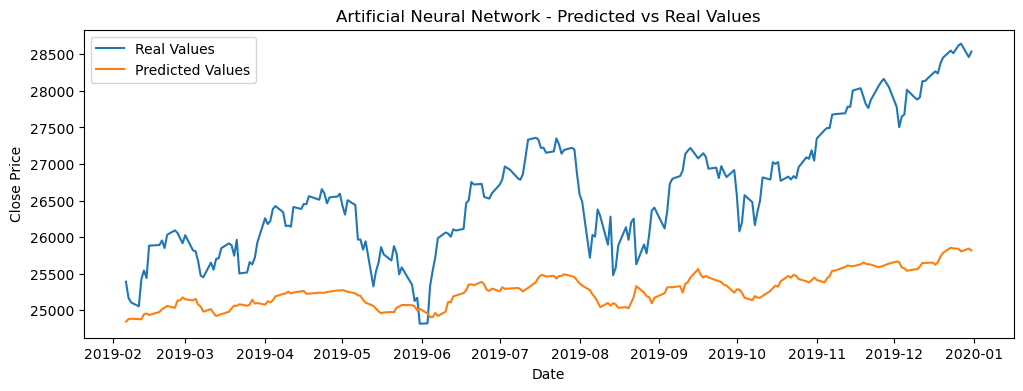

In [500]:
# Plotting the predicted values and real values
plt.figure(figsize=(12, 4))
plt.plot(test_data.iloc[time_window:].index, y_test, label='Real Values')
plt.plot(test_data.iloc[time_window:].index, y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Artificial Neural Network - Predicted vs Real Values')
plt.legend()
plt.show()

In [501]:
# saving the prediction price for further use
y_pred_ann = pd.DataFrame(y_pred)

# Rename the column
y_pred_ann = y_pred_ann.rename(columns={0: 'Predicted'})

# Add 10 rows with NaN values at the top
y_pred_ann = pd.concat([pd.DataFrame(np.nan,
                                    index=np.arange(time_window),
                                    columns=['Predicted']), y_pred_ann],
                      ignore_index=True)

# **Hybrid Strategies**

## **hTEMA**

In [502]:
def htema_strategy(df, symbol, short_period, mid_period, long_period, y_pred):
    """
    Implements a trading strategy based on Hull Triple Exponential Moving Average (HTEMA).

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the ShortEMA.
        mid_period (int): Mid period for calculating the MidEMA.
        long_period (int): Long period for calculating the LongEMA.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate EMAs for different periods
    temp['ShortEMA'] = ema(df, short_period)
    temp['MidEMA'] = ema(df, mid_period)
    temp['LongEMA'] = ema(df, long_period)
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on EMAs
    temp['StrategyPosition'] = np.where((temp['ShortEMA'] > temp['MidEMA']) & (temp['ShortEMA'] > temp['LongEMA']), 1,
                                np.where((temp['ShortEMA'] < temp['MidEMA']) & (temp['ShortEMA'] < temp['LongEMA']), -1, 0))
    
    # Determine overall position based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy based on log returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol].shift(1))
    temp['Strategy'] = temp.Position.shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [515]:
htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr)


,DJI,ShortEMA,MidEMA,LongEMA,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,
2019-01-02,23346.240234,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,22686.220703,22851.225586,NaN,NaN,NaN,0,0,0,-0.028678,-0.000000,-660.019531,-0.000000,0.0,0.971729,1.000000,-660.019531,0.000000
2019-01-04,23433.160156,23254.103365,NaN,NaN,NaN,0,0,0,0.032394,0.000000,746.939453,0.000000,0.0,1.003723,1.000000,86.919922,0.000000
2019-01-07,23531.349609,23441.244580,NaN,NaN,NaN,0,0,0,0.004181,0.000000,98.189453,0.000000,0.0,1.007929,1.000000,185.109375,0.000000
2019-01-08,23787.449219,23673.001404,23502.744890,NaN,NaN,0,0,0,0.010825,0.000000,256.099609,0.000000,0.0,1.018899,1.000000,441.208984,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.449219,28512.180778,28434.620487,28353.782326,28499.999224,1,1,1,-0.001264,-0.001264,-36.080078,-36.080078,0.0,1.221415,1.652488,5169.208984,13128.564453
2019-12-26,28621.390625,28584.987343,28496.877200,28413.250837,28493.845413,1,1,1,0.003708,0.003708,105.941406,105.941406,0.0,1.225953,1.658627,5275.150391,13234.505859
2019-12-27,28645.259766,28625.168958,28546.338055,28464.808376,28605.739704,-1,1,1,0.000834,0.000834,23.869141,23.869141,0.0,1.226975,1.660010,5299.019531,13258.375000


### **Comparing TEMA and hTEMA**

In [504]:
calculate_metrics(tema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,59.0,2539.900391,1.182278,43.049159,-2763.917969


In [505]:
calculate_metrics(htema_strategy(test_data, index_name, best_tema_params[0], best_tema_params[1], best_tema_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,54.0,13075.255859,2.384003,242.134368,-1014.199219


## **hMACD**

In [506]:
def hmacd_strategy(df, symbol, short_period, long_period, signal_period, y_pred):
    """
    Implements a trading strategy based on the Moving Average Convergence Divergence (MACD) indicator.

    Args:
        df (pandas.DataFrame): Input dataframe containing historical price data.
        symbol (str): Name of the column in the dataframe that represents the price data.
        short_period (int): Short period for calculating the short exponential moving average (ShortEMA).
        long_period (int): Long period for calculating the long exponential moving average (LongEMA).
        signal_period (int): Signal period for calculating the signal line.
        y_pred (pandas.DataFrame): Dataframe containing predicted values.

    Returns:
        pandas.DataFrame: The updated dataframe with additional columns representing the strategy and performance metrics.
    """
    
    df = df_change(df, symbol)
    temp = df.copy() # Make a copy of the dataframe
    
    # Calculate MACD line using short and long EMAs
    temp['ShortEMA'] = ema(df, short_period)
    temp['LongEMA'] = ema(df, long_period)
    temp['MACD Line'] = temp['ShortEMA'] - temp['LongEMA']
    
    # Calculate signal line
    temp['Signal Line'] = ema(temp, signal_period)['MACD Line']
    
    # Add predicted prices and prediction positions to the dataframe
    temp['PredictionPrice'] = y_pred['Predicted'].values
    temp['PredictionPosition'] = np.where((temp['PredictionPrice'] < temp[symbol].shift(-1)), 1,
                                          np.where(temp['PredictionPrice'] > temp[symbol].shift(-1), -1, 0))
    
    # Determine strategy position based on MACD line and signal line
    temp['StrategyPosition'] = np.where(temp['MACD Line'] > temp['Signal Line'], 1,
                                np.where(temp['MACD Line'] < temp['Signal Line'], -1, 0))
    
    # Generate trading signals based on strategy position and prediction position
    temp['Position'] = np.where((temp['StrategyPosition'] == 1) | (temp['PredictionPosition'] == 1), 1,
                            np.where((temp['StrategyPosition'] == -1) & (temp['PredictionPosition'] == -1), -1, 0))
    
    # Calculate log returns and strategy returns
    temp['LogReturns'] = np.log(temp[symbol]) - np.log(temp[symbol]).shift(1)
    temp['Strategy'] = temp['Position'].shift(1) * temp['LogReturns']
    
    # Calculate profit based on price
    temp['PriceChange'] = temp[symbol] - temp[symbol].shift(1)
    temp['PriceStrategy'] = temp.Position.shift(1) * temp['PriceChange']
    
    # Calculate the number of trades and convert double trades to single trades
    temp['Trades'] = temp.Position.diff().fillna(0).abs()
    temp['Trades'] = temp['Trades'].replace(2, 1)
    
    # Calculate cumulative log returns, cumulative strategy returns, cumulative price change, and cumulative price strategy
    temp['CLogReturns'] = temp['LogReturns'].cumsum().apply(np.exp)
    temp["CStrategy"] = temp['Strategy'].cumsum().apply(np.exp)
    temp['CPrice'] = -(df[symbol].iloc[0] - df[symbol])
    temp['CPriceStrategy'] = temp['PriceStrategy'].cumsum()
    
    return temp

In [507]:
hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr)

,DJI,ShortEMA,LongEMA,MACD Line,Signal Line,PredictionPrice,PredictionPosition,StrategyPosition,Position,LogReturns,Strategy,PriceChange,PriceStrategy,Trades,CLogReturns,CStrategy,CPrice,CPriceStrategy
Date,,,,,,,,,,,,,,,,,,
2019-01-02,23346.240234,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-0.000000,NaN
2019-01-03,22686.220703,22851.225586,NaN,NaN,NaN,NaN,0,0,0,-0.028678,-0.000000,-660.019531,-0.000000,0.0,0.971729,1.000000,-660.019531,0.000000
2019-01-04,23433.160156,23254.103365,NaN,NaN,NaN,NaN,0,0,0,0.032394,0.000000,746.939453,0.000000,0.0,1.003723,1.000000,86.919922,0.000000
2019-01-07,23531.349609,23441.244580,NaN,NaN,NaN,NaN,0,0,0,0.004181,0.000000,98.189453,0.000000,0.0,1.007929,1.000000,185.109375,0.000000
2019-01-08,23787.449219,23673.001404,23502.744890,170.256514,NaN,NaN,0,0,0,0.010825,0.000000,256.099609,0.000000,0.0,1.018899,1.000000,441.208984,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28515.449219,28512.180778,28434.620487,77.560291,87.957844,28499.999224,1,-1,1,-0.001264,-0.001264,-36.080078,-36.080078,0.0,1.221415,1.531984,5169.208984,11331.779297
2019-12-26,28621.390625,28584.987343,28496.877200,88.110143,88.008610,28493.845413,1,1,1,0.003708,0.003708,105.941406,105.941406,0.0,1.225953,1.537676,5275.150391,11437.720703
2019-12-27,28645.259766,28625.168958,28546.338055,78.830903,84.949374,28605.739704,-1,-1,-1,0.000834,0.000834,23.869141,23.869141,1.0,1.226975,1.538958,5299.019531,11461.589844


### **Comparing MACD and hMACD**

In [508]:
calculate_metrics(macd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2]))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,71.0,-1903.876953,0.886928,-26.815168,-3099.941406


In [509]:
calculate_metrics(hmacd_strategy(test_data, index_name, best_macd_params[0], best_macd_params[1], best_macd_params[2], y_pred_lr))

,Number of Trades,Net Profit,Profit Factor,Average Net per Trade,Maximum Drawdown
Strategy,63.0,11568.410156,2.047549,183.625558,-1478.376953
